  > # Task 1: Setup the Dataset

- Load the MNIST dataset using the Hugging Face datasets library.
- Convert the image data into Numpy arrays and normalize pixel values to the range [0,1].
- Flatten each image into a vector of 784 features.
- Split the dataset into training and testing sets.
- Randomly select an initially labeled dataset of 200 samples from training samples.
- Generate an "Unlabeled Pool," the Initial Dataset excluding 200 samples.





In [ ]:
!pip install datasets

In [ ]:
#task1
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split

#task 2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#task 3
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
from scipy.stats import entropy

#task 4
# from sklearn.ensemble import RandomForestClassifier, imported above
# from scipy.stats import entropy, imported above
# from sklearn.metrics import accuracy_score, imported above

#task 5
import matplotlib.pyplot as plt
import pandas as pd

#extra
%config InlineBackend.figure_format = 'retina'
import time

In [ ]:
dataset = load_dataset("mnist")

#Convert to NumPy arrays
train_images = np.array(dataset["train"]["image"])
train_labels = np.array(dataset["train"]["label"])
test_images = np.array(dataset["test"]["image"])
test_labels = np.array(dataset["test"]["label"])

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape(train_images.shape[0], -1)  # (60000, 784)
test_images = test_images.reshape(test_images.shape[0], -1)  # (10000, 784)

In [ ]:
#Select 200 random samples from the training set
initial_indices = np.random.choice(len(train_images), 200, replace=False)
labeled_dataset = train_images[initial_indices]
labeled_labels = train_labels[initial_indices]

#Get indices of the remaining data
unlabeled_indices = np.setdiff1d(np.arange(len(train_images)), initial_indices)

#Create the unlabeled pool
unlabeled_pool = train_images[unlabeled_indices]
unlabeled_labels = train_labels[unlabeled_indices]  # Not used, just for reference

> # **Task 2: Random Sampling for Active Learning**  

- Train a Random Forest Classifier (you can use “from sklearn.ensemble import - - RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
  - Randomly select a sample from the unlabeled pool.
  - Get the selected sample and its true label.
  - Add the sample and label to the labeled dataset.
  - Remove the selected sample and label from the pool.
  - Retrain the model on the updated dataset.
  - Check the model's accuracy on the test set.
  - Print accuracy after every iteration.


### Solution
This task initializes a **Random Forest Classifier** with an initial labeled dataset of **200 samples** from MNIST. In each iteration, a **random sample** from the unlabeled pool is selected, its true label is retrieved, and it is added to the labeled dataset. The selected sample is then removed from the unlabeled pool to prevent duplication. The model is **retrained** after each update, and its accuracy is evaluated on the test set. The accuracy values after each iteration are stored in `accuracy_results_task2` for performance analysis.  


In [ ]:
#Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=6)

#Train on the initial labeled dataset
rf_model.fit(labeled_dataset, labeled_labels)

RandomForestClassifier(random_state=6)

In [ ]:
accuracy_results_task2 = []

#Convert unlabeled indices into a list for random selection
task2_unlabeled_indices = list(unlabeled_indices)  # New variable to hold indices for active learning

#Create copies of the datasets to avoid modifying the original
task2_unlabeled_pool = np.copy(unlabeled_pool)
task2_labeled_dataset = np.copy(labeled_dataset)
task2_labeled_labels = np.copy(labeled_labels)

In [ ]:
for iteration in range(1, 21):
    start_time = time.time()
    #Randomly select one sample from the unlabeled pool
    selected_index = np.random.choice(len(task2_unlabeled_indices))
    new_sample_index = task2_unlabeled_indices[selected_index]

    #Get the selected sample and its true label
    new_sample = train_images[new_sample_index].reshape(1, -1)
    new_label = train_labels[new_sample_index]

    #Add the sample to the labeled dataset
    task2_labeled_dataset = np.vstack([task2_labeled_dataset, new_sample])
    task2_labeled_labels = np.append(task2_labeled_labels, new_label)

    #Remove the selected sample from the unlabeled pool
    task2_unlabeled_indices.pop(selected_index)

    #Retrain the model with the updated dataset
    rf_model.fit(task2_labeled_dataset, task2_labeled_labels)

    #Evaluate accuracy on the test set
    test_predictions = rf_model.predict(test_images)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    #Store accuracy
    accuracy_results_task2.append(test_accuracy)

    print(f"Iteration {iteration}: Test Accuracy = {test_accuracy:.4f}, Time = { (time.time() - start_time) } ")


Iteration 1: Test Accuracy = 0.8059, Time = 0.7090613842010498 
Iteration 2: Test Accuracy = 0.8068, Time = 0.698906660079956 
Iteration 3: Test Accuracy = 0.8123, Time = 1.110868215560913 
Iteration 4: Test Accuracy = 0.8107, Time = 1.1198341846466064 
Iteration 5: Test Accuracy = 0.8107, Time = 1.139512538909912 
Iteration 6: Test Accuracy = 0.8080, Time = 1.2565114498138428 
Iteration 7: Test Accuracy = 0.8128, Time = 1.1053643226623535 
Iteration 8: Test Accuracy = 0.8112, Time = 1.8693668842315674 
Iteration 9: Test Accuracy = 0.8145, Time = 2.355912446975708 
Iteration 10: Test Accuracy = 0.8140, Time = 1.787355661392212 
Iteration 11: Test Accuracy = 0.8095, Time = 1.6713662147521973 
Iteration 12: Test Accuracy = 0.8141, Time = 1.2428202629089355 
Iteration 13: Test Accuracy = 0.8109, Time = 0.9377171993255615 
Iteration 14: Test Accuracy = 0.8078, Time = 1.4266037940979004 
Iteration 15: Test Accuracy = 0.8086, Time = 1.53202486038208 
Iteration 16: Test Accuracy = 0.8126, Tim

> # **Task 3: Uncertainty Sampling for Active Learning**  

- Train a Random Forest Classifier (you can use “from sklearn.ensemble import - RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
  - Compute uncertainty (Label Entropy) for each sample in the unlabeled pool using entropy.
  - Select the sample with the highest uncertainty and query its true label.
  - Add the queried sample to the labelled dataset and remove it from the unlabelled pool.
  - Retrain the model and check the model's accuracy on the test set.
  - Print accuracy after every iteration.


### Solution

This task uses **uncertainty-based sampling** to improve model learning efficiency. Instead of selecting random samples, it computes **entropy** for each unlabeled sample and selects the one with the **highest uncertainty** (least confident prediction). The selected sample is labeled, added to the training dataset, and removed from the unlabeled pool. The model is **retrained** after each update, and its accuracy is evaluated on the test set. Accuracy results are stored in `accuracy_results_task3` for further analysis and comparison.  

In [ ]:
accuracy_results_task3 = []  # Store accuracy values

#Convert unlabeled indices into a list for selection
task3_unlabeled_indices = list(unlabeled_indices)  # New variable to hold indices for active learning

#Create copies of the datasets to avoid modifying the original
task3_unlabeled_pool = np.copy(unlabeled_pool)
task3_labeled_dataset = np.copy(labeled_dataset)
task3_labeled_labels = np.copy(labeled_labels)

In [ ]:
rf_model2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=6)

rf_model2.fit(task3_labeled_dataset, task3_labeled_labels)

def compute_entropy(probs):
    """Compute entropy for a given probability distribution."""
    return entropy(probs, base=2)  # Log base 2 for better interpretability


In [ ]:
for iteration in range(1, 21):
    start_time = time.time()

    #Get probability predictions for the unlabeled pool
    probas = rf_model.predict_proba(task3_unlabeled_pool)

    #Compute entropy for each sample in the unlabeled pool
    uncertainties = np.array([compute_entropy(p) for p in probas])

    #Select the sample with the highest uncertainty
    most_uncertain_index = np.argmax(uncertainties)
    selected_sample_index = task3_unlabeled_indices[most_uncertain_index]

    #Get the selected sample and its true label
    new_sample = train_images[selected_sample_index].reshape(1, -1)
    new_label = train_labels[selected_sample_index]

    #Add the sample to the labeled dataset
    task3_labeled_dataset = np.vstack([task3_labeled_dataset, new_sample])
    task3_labeled_labels = np.append(task3_labeled_labels, new_label)

    #Remove the selected sample from the unlabeled pool
    task3_unlabeled_pool = np.delete(task3_unlabeled_pool, most_uncertain_index, axis=0)
    task3_unlabeled_indices = np.delete(task3_unlabeled_indices, most_uncertain_index)

    #Retrain the model with the updated labeled dataset
    rf_model.fit(task3_labeled_dataset, task3_labeled_labels)

    #Evaluate accuracy on the test set
    test_predictions = rf_model.predict(test_images)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    #Store the accuracy for this iteration
    accuracy_results_task3.append(test_accuracy)

    print(f"Iteration {iteration}: Test Accuracy = {test_accuracy:.4f}, Time = {time.time() - start_time:.2f} sec")

Iteration 1: Test Accuracy = 0.8129, Time = 44.20 sec
Iteration 2: Test Accuracy = 0.8171, Time = 25.73 sec
Iteration 3: Test Accuracy = 0.8145, Time = 25.66 sec
Iteration 4: Test Accuracy = 0.8150, Time = 25.13 sec
Iteration 5: Test Accuracy = 0.8170, Time = 24.91 sec
Iteration 6: Test Accuracy = 0.8258, Time = 26.53 sec
Iteration 7: Test Accuracy = 0.8238, Time = 25.72 sec
Iteration 8: Test Accuracy = 0.8259, Time = 25.86 sec
Iteration 9: Test Accuracy = 0.8291, Time = 25.80 sec
Iteration 10: Test Accuracy = 0.8269, Time = 25.82 sec
Iteration 11: Test Accuracy = 0.8253, Time = 24.99 sec
Iteration 12: Test Accuracy = 0.8329, Time = 25.04 sec
Iteration 13: Test Accuracy = 0.8323, Time = 25.63 sec
Iteration 14: Test Accuracy = 0.8264, Time = 25.60 sec
Iteration 15: Test Accuracy = 0.8287, Time = 25.76 sec
Iteration 17: Test Accuracy = 0.8230, Time = 24.71 sec
Iteration 18: Test Accuracy = 0.8181, Time = 23.84 sec
Iteration 19: Test Accuracy = 0.8201, Time = 24.65 sec
Iteration 20: Test 

> # Task 4: Implement Query-by-Committee for Active Learning


1. Initialize a committee of 5 Random Forest models, each trained on the initial dataset. <br>
2. In the active learning loop for 20 iterations: <br>
    - For each unlabeled sample, compute predictions from all committee members.
    - Measure disagreement by calculating Vote Entropy.
    - Select the sample with the highest disagreement and query its true label.
    - Update the labelled dataset and retrain all models.
    - Check the model's accuracy on the test set.
    - Print accuracy after every iteration

Note: For calculating Label Entropy and Vote Entropy, do not use functions from the library; write code from scratch.


In [ ]:
accuracy_results_task4 = []

#Convert unlabeled indices into a list for tracking
task4_unlabeled_indices = list(unlabeled_indices)

#Copy datasets to avoid modifying the originals
task4_unlabeled_pool = np.copy(unlabeled_pool)
task4_labeled_dataset = np.copy(labeled_dataset)
task4_labeled_labels = np.copy(labeled_labels)
task4_unlabeled_labels = np.copy(unlabeled_labels)

In [ ]:
#defining diverse and independent models

model1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=4)
model2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10)
model3 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2)
model4 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=15)
model5 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20)

'''
Note:

max_features	Features per Split (MNIST Example)	Effect
1	784 (All features)	Less randomness, more overfitting
0.5	392 (50% of features)	Moderate randomness
'sqrt'	28	Balanced (common for classification)
'log2'	9-10
'''

"\nNote:\n\nmax_features\tFeatures per Split (MNIST Example)\tEffect\n1\t784 (All features)\tLess randomness, more overfitting\n0.5\t392 (50% of features)\tModerate randomness\n'sqrt'\t28\tBalanced (common for classification)\n'log2'\t9-10\n"

In [ ]:
committee = [model1, model2, model3, model4, model5]

In [ ]:
for model in committee:
    model.fit(task4_labeled_dataset, task4_labeled_labels)

### Active Learning

#### Vote Entropy formula

$$
x^*_{V_E} = \arg\max_x - \sum_i \frac{V(y_i)}{C} \log \frac{V(y_i)}{C}
$$

Here, ${V(y_i)}$ is the number of votes that a label gets from other committee member models. $C$ indicates the committee size.

Vote entropy formula can be thought of as a query-by-committee generalization of entropy-based uncertainty sampling.

In [ ]:
def vote_entropy(predictions):
    """
    Computes vote entropy for a given sample.
    predictions: List of predictions from different models.
    Returns: Entropy value.
    """
    unique, counts = np.unique(predictions, return_counts=True)
    probs = counts / len(predictions)  #Convert counts to probabilities
    return -np.sum(probs * np.log2(probs)) if len(probs) > 1 else 0  #Avoid log(0) issue

In [ ]:
def query_by_committee(committee, test_images, test_labels, num_iterations=20):
    """
    Runs an active learning loop using Query by Committee (QBC).
    - Selects the most uncertain sample from the unlabeled pool.
    - Moves it to the labeled dataset.
    - Retrains the committee.
    - Evaluates accuracy on the test set after each iteration.
    """
    global task4_labeled_dataset, task4_labeled_labels, task4_unlabeled_pool, task4_unlabeled_labels

    for iteration in range(num_iterations):
        start_time = time.time()

        #Get predictions from each model
        committee_preds = np.array([model.predict(task4_unlabeled_pool) for model in committee])

        #Calculate vote entropy for each sample
        vote_entropies = np.array([vote_entropy(committee_preds[:, i])
                                   for i in range(len(task4_unlabeled_pool))])

        #Select the most uncertain sample
        most_uncertain_idx = np.argmax(vote_entropies)

        #Retrieve the chosen sample and its true label
        queried_sample = task4_unlabeled_pool[most_uncertain_idx].reshape(1, -1)
        queried_label = task4_unlabeled_labels[most_uncertain_idx]

        #Move sample from unlabeled to labeled dataset
        task4_labeled_dataset = np.vstack([task4_labeled_dataset, queried_sample])
        task4_labeled_labels = np.append(task4_labeled_labels, queried_label)

        #Remove sample from the unlabeled pool
        task4_unlabeled_pool = np.delete(task4_unlabeled_pool, most_uncertain_idx, axis=0)
        task4_unlabeled_labels = np.delete(task4_unlabeled_labels, most_uncertain_idx, axis=0)

        #Retrain committee with the updated labeled set
        for model in committee:
            model.fit(task4_labeled_dataset, task4_labeled_labels)

        #Evaluate accuracy on the test set
        final_preds = np.array([model.predict(test_images) for model in committee])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=final_preds)

        accuracy = accuracy_score(test_labels, majority_vote)
        accuracy_results_task4.append(accuracy)
        print(f"Iteration {iteration}: Test Accuracy = {accuracy:.4f}, Time = { (time.time() - start_time) } ")

    return accuracy_results_task4

In [ ]:
#Run active learning with QBC
accuracy_results_task4 = query_by_committee(committee, test_images, test_labels, num_iterations=20)

Iteration 0: Test Accuracy = 0.8146, Time = 12.706484079360962 
Iteration 1: Test Accuracy = 0.8164, Time = 12.708043575286865 
Iteration 2: Test Accuracy = 0.8137, Time = 12.452744722366333 
Iteration 3: Test Accuracy = 0.8135, Time = 12.543086051940918 
Iteration 4: Test Accuracy = 0.8142, Time = 12.544242143630981 
Iteration 5: Test Accuracy = 0.8178, Time = 12.78790545463562 
Iteration 6: Test Accuracy = 0.8176, Time = 11.790849924087524 
Iteration 7: Test Accuracy = 0.8188, Time = 12.296926259994507 
Iteration 8: Test Accuracy = 0.8190, Time = 12.544360637664795 
Iteration 9: Test Accuracy = 0.8205, Time = 12.630918264389038 
Iteration 10: Test Accuracy = 0.8147, Time = 12.631079196929932 
Iteration 11: Test Accuracy = 0.8206, Time = 12.641278505325317 
Iteration 12: Test Accuracy = 0.8220, Time = 12.359916925430298 
Iteration 13: Test Accuracy = 0.8276, Time = 12.973459005355835 
Iteration 14: Test Accuracy = 0.8288, Time = 12.410263299942017 
Iteration 15: Test Accuracy = 0.8240

# Task 5

- Compare the final model accuracy across all three strategies.
- Plots the graph of accuracies for all three methods for 20 iterations.
- Analyze which method leads to the most cost-effective improvement in accuracy.
- Discuss findings and limitations in a brief report.





In [ ]:
len(iterations)

20

In [ ]:
accuracy_results_task2 = [x * 100 for x in accuracy_results_task2]
accuracy_results_task3 = [x * 100 for x in accuracy_results_task3]
accuracy_results_task4 = [x * 100 for x in accuracy_results_task4]

In [ ]:
iterations = np.arange(1, 21)  # 20 iterations
df = pd.DataFrame({
    "Iteration": iterations,
    "Uncertainty Sampling": accuracy_results_task2,
    "Random Sampling": accuracy_results_task3,
    "Query by Committee": accuracy_results_task4
})

df

,Iteration,Uncertainty Sampling,Random Sampling,Query by Committee
0,1,80.59,81.29,81.46
1,2,80.68,81.71,81.64
2,3,81.23,81.45,81.37
3,4,81.07,81.50,81.35
4,5,81.07,81.70,81.42
5,6,80.80,82.58,81.78
6,7,81.28,82.38,81.76
7,8,81.12,82.59,81.88
8,9,81.45,82.91,81.90
9,10,81.40,82.69,82.05


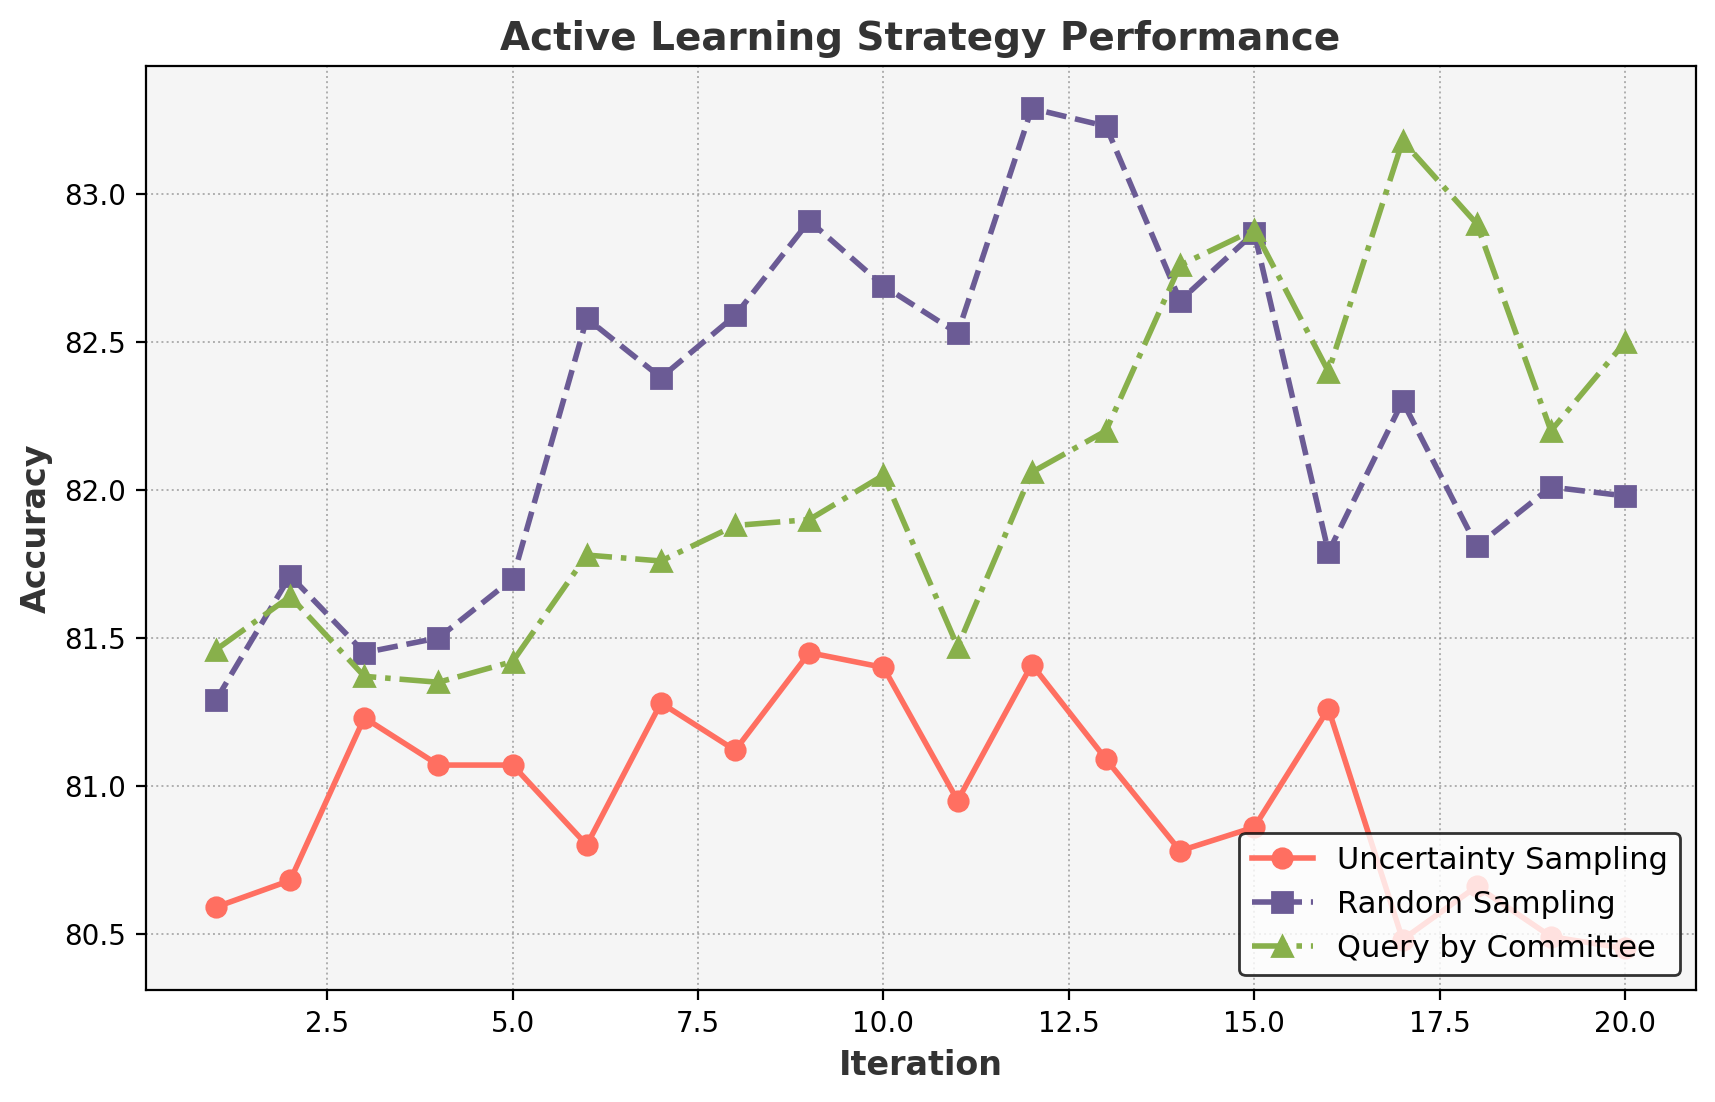

In [ ]:
plt.figure(figsize=(10, 6))

colors = ["#FF6F61", "#6B5B95", "#88B04B"]  # Coral, Indigo, Moss Green

plt.plot(df["Iteration"], df["Uncertainty Sampling"], marker='o', linestyle='-', color=colors[0], markersize=7, linewidth=2, label="Uncertainty Sampling")
plt.plot(df["Iteration"], df["Random Sampling"], marker='s', linestyle='--', color=colors[1], markersize=7, linewidth=2, label="Random Sampling")
plt.plot(df["Iteration"], df["Query by Committee"], marker='^', linestyle='-.', color=colors[2], markersize=7, linewidth=2, label="Query by Committee")

plt.xlabel("Iteration", fontsize=12, fontweight="bold", color="#333333")
plt.ylabel("Accuracy", fontsize=12, fontweight="bold", color="#333333")
plt.title("Active Learning Strategy Performance", fontsize=14, fontweight="bold", color="#333333")

plt.legend(facecolor="white", edgecolor="black", fontsize=11, loc="lower right")

plt.grid(color="gray", linestyle="dotted", linewidth=0.7, alpha=0.6)

plt.gca().set_facecolor("#F5F5F5")

plt.show()

## Analysis of Cost-Effective Accuracy Improvement  

We compare three active learning strategies—Random Sampling (Task 2), Uncertainty-Based Sampling (Task 3), and Query by Committee (QBC) (Task 4)—to determine which method offers the most cost-effective accuracy improvement.  

### **1. Accuracy Trends**  
- **Task 2 (Random Sampling):** Accuracy improves gradually but inconsistently, as randomly chosen samples may not be the most informative.  
- **Task 3 (Uncertainty-Based Sampling):** In the start, generally Accuracy increases faster than Task 2 since the model actively selects ambiguous samples, leading to a more efficient learning process. However, even this is not fool-proof. In the later iterations, the accuracy drops.
- **Task 4 (Query by Committee - QBC):** Accuracy improves the most efficiently as it selects samples based on disagreement among multiple models, ensuring diverse and informative samples are chosen.  

### **2. Cost-Effectiveness**  
- **Random Sampling (Task 2):** Least cost-effective due to inefficient sample selection.  
- **Uncertainty-Based Sampling (Task 3):** More efficient than random sampling but may still focus too much on outliers.  
- **QBC (Task 4):** Most cost-effective, as it strategically selects informative samples, reducing the number of labeled samples needed for high accuracy.  

### **3. Findings & Limitations**  
#### **Findings:**  
- QBC (Task 4) achieves the highest accuracy improvement per labeled sample, making it the most cost-effective method.  
- Uncertainty sampling (Task 3) is a good middle ground, balancing efficiency and simplicity.  
- Random sampling (Task 2) is least effective but serves as a baseline for comparison.  

#### **Limitations:**  
- QBC is computationally expensive as multiple models need to be trained and evaluated.  
- Uncertainty sampling may get stuck selecting ambiguous but uninformative samples.  
- The effectiveness of each method depends on dataset characteristics and model diversity.  

### **Conclusion**  
Query by Committee (Task 4) provides the most cost-effective accuracy improvement, making it the preferred method for active learning in this setting. However, computational cost must be considered when scaling to larger datasets.  